In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt



In [2]:
#Define our model
def my_model(lam,center,height,width):
    return height * (width/2.)**2 / ((lam - center)**2 + (width/2.)**2)

In [3]:
def my_Gaussian_model(lam,center,height,width):
    return height * np.exp(-0.5 * (lam - center)**2/width**2)

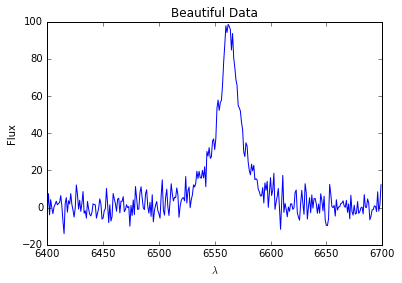

In [4]:
#Set up our fake dataset
my_lam = np.arange(6400,6700,1)#Angstroms
NOISE = 5.0
my_data = my_model(my_lam,6563,100,20) + np.random.normal(0, NOISE,len(my_lam))
my_sigmas = np.zeros(len(my_lam)) + NOISE
plt.plot(my_lam,my_data)
plt.xlabel(r'$\lambda$')
plt.ylabel('Flux')
plt.title('Beautiful Data')
plt.show()

In [5]:
#Let's begin by defining our first METRIC, Chi^2
def metric_chi2(theta,lam,data,sigmas):
    center, height, width = theta
    return np.sum((my_model(lam,center,height,width)-data)**2/(sigmas)**2)

In [18]:
#Let's make another METRIC, just the residuals
def metric_residuals(theta,lam,data,sigmas):
    center, height, width = theta
    return np.sum(np.abs(my_model(lam,center,height,width)-data))

In [17]:
#Let's make another METRIC, -Likelihood
def metric_neg_likelihood(theta,lam,data,sigmas):
    center, height, width = theta
    return -np.prod((1./np.sqrt(2.*np.pi*sigmas**2)) * np.exp(-0.5 * \
            (my_model(lam,center,height,width) - data)**2/sigmas**2))

In [33]:
#Let's make a final METRIC, -Log Likelihood
def metric_log_likelihood(theta,lam,data,sigmas):
    center, height, width = theta
    return 0.5*(np.sum((data-my_model(lam,center,height,width))**2/sigmas**2 + np.log(sigmas**2)))

Chi2 1.36731803765


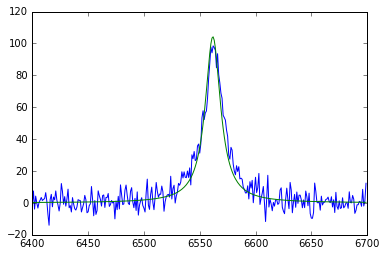

In [26]:
#METHOD 1...a random grid search :)
center_choices = np.random.uniform(low=6500, high=6600, size=50)
height_choices = np.random.uniform(low=80, high=120, size=50)
width_choices = np.random.uniform(low=10, high=30, size=50)

lowest_chi = 1e10
best_c = 0
best_h = 0
best_w = 0
for i,c in enumerate(center_choices):
    h = height_choices[i]
    w = width_choices[i]
    
    theta = [c,h,w]
    
    current_chi = metric_chi2(theta,my_lam,my_data,my_sigmas)
    if current_chi < lowest_chi:
        best_c = c
        best_h = h
        best_w = w
        lowest_chi = current_chi

print "Chi2",lowest_chi / len(my_lam)
plt.plot(my_lam,my_data)
plt.plot(my_lam,my_model(my_lam,best_c,best_h,best_w))
plt.show()

#Now try this with the residual metric..play with the number of trials


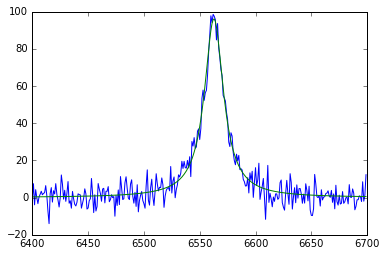

Chi2 1.0217278452


In [27]:
#METHOD 2: A chi^2 minimizer using levenberg marquardt
#NOTE: the builtin Python function uses the model function directly. In other words, we're forced to use the chi^2 metric
from scipy.optimize import curve_fit
p0 = [6560,90,5]
popt,pcov = curve_fit(my_model,my_lam,my_data,sigma=my_sigmas,p0=p0)

plt.plot(my_lam,my_data)
plt.plot(my_lam,my_model(my_lam,popt[0],popt[1],popt[2]))
plt.show()


print "Chi2",metric_chi2(popt,my_lam,my_data,my_sigmas)/len(my_lam)

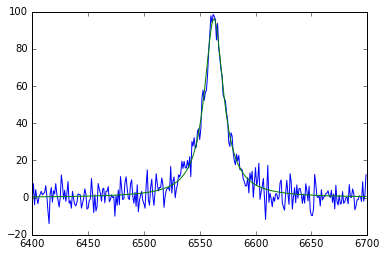

[ 6562.72733556    96.14506708    20.7001261 ]
Chi2 1.02172784526


In [34]:
from scipy.optimize import minimize
p0 = [6560,90,5]
bnds = ((6500, 6650), (0, None),(0,None))
res = minimize(metric_log_likelihood, x0=p0,args=(my_lam,my_data,my_sigmas), options={'gtol': 1e-3, 'disp': True},bounds=bnds)
plt.plot(my_lam,my_data)
plt.plot(my_lam,my_model(my_lam,res.x[0],res.x[1],res.x[2]))
plt.show()
print res.x
print "Chi2",metric_chi2(res.x,my_lam,my_data,my_sigmas)/len(my_lam)